# TOMAS basics

**Authors:** Qiuyu Lian, Ziqi Rong

In this tutorial, we introduce how to harness doublets to infer the total mRNA ratio with `TOMAS` in a basic scenario where there are only two cell types and the droplet labels are available. 

We use the powerful data structure [AnnData](https://anndata.readthedocs.io/en/latest/#) to support basic operations of scRNA-seq data.

In [1]:
import tomas as tm
import scanpy as sc
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

Let's show the analysis steps of `TOMAS` with a simulated dataset ([download](https://github.com/QiuyuLian/TOMAS/blob/main/examples/simulated_data/adata_bc.h5ad)) .
The droplet labels are stored in `adata.obs`. In the basic case with two biological cell types, there should be at least three categories of droplets, including two kinds of homotypic droplets and one category of heterotypic doublets. We first shows one simulated datasets with ground truth of total-mRNA ratio set as 6.

In [2]:
adata = sc.read_h5ad('examples/simulated_data/adata_bc.h5ad')
adata.obs.head(3)  # -1 means not applicable. the values are set to be meaningful only for identified heterodbls.

,danno,trueR
9997,naive,-1.0
4972,naive,-1.0
6154,naive,-1.0


In [3]:
np.unique(adata.obs['danno'],return_counts=True)

(array(['active', 'naive', 'naive_active'], dtype=object),
 array([500, 500,  50]))

Display UMI amount distribution.

In [4]:
adata.obs['total_UMIs'] = np.ravel(adata.X.sum(1))
adata.obs['log10_totUMIs'] = np.log10(adata.obs['total_UMIs'])

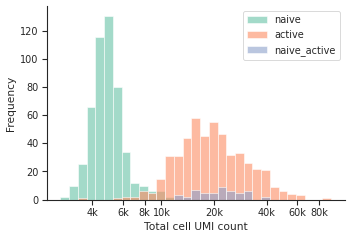

In [5]:
tm.vis.UMI_hist(adata,
                x_hist='log10_totUMIs',
                groupby='danno')


Fit total UMI amounts with log-Normal distribution

In [6]:
tm.fit.logN_para(adata,
                 logUMIby='log10_totUMIs',
                 groupby='danno',
                 inplace=True)

## Fit Dirichlet-Multinomial (DMN) Model

Fit Dirichlet-Multinomial (DMN) model each kind of homo-typic droplet populations. The optimizated paremeters `Alpha` of each cell types is stroed in `adata.varm['para_diri']` as a `pandas.DataFrame`. 

In [7]:
tm.fit.dmn(adata,
           groupby='danno',
           groups=['naive','active'], # in parallel 
           verbose=2,
           verbose_interval = 100) 

Initialization 0
Initialization 0
  Iteration 100	 time lapse 17.73145s	 ll change 0.06908
  Iteration 100	 time lapse 21.27625s	 ll change 0.11554
  Iteration 200	 time lapse 17.15888s	 ll change 0.00705
  Iteration 200	 time lapse 20.63510s	 ll change 0.00136
Initialization converged: True	 time lapse 43.77694s	 ll -155481.59025
active is done!
  Iteration 300	 time lapse 17.20211s	 ll change 0.00142
Initialization converged: True	 time lapse 56.56639s	 ll -34880.77653
naive is done!


## Merge genes into exclusive meta-genes

We fuse a bunch of genes into a meta-gene to mitigate the curse of dimensionality and, meanwhile, maintain information to deconvolute doublets. 

In [8]:
t0 = time.time()

adata_dbl_mg = tm.infer.get_dbl_mg_bc(adata,
                                     groupby = 'danno',
                                     dblgroup = 'naive_active') 

print(time.time()-t0)

1.862058401107788


## Estimate $R$ with synthetic droplets

Initialized.
Iteration 2	time lapse 6.879041910171509s	ll change 273.54083313515

Iteration 4	time lapse 6.8104541301727295s	ll change 0.44074532789818477

Iteration 6	time lapse 6.881932973861694s	ll change 0.062414051295490935

Iteration 8	time lapse 6.8667919635772705s	ll change 0.011999675014521927



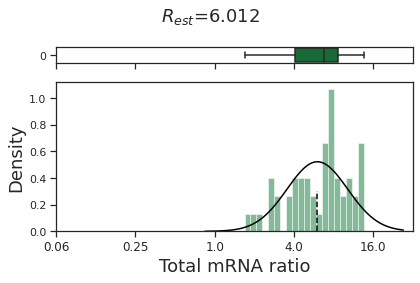

In [9]:
t0 = time.time()
tm.infer.ratios_bc(adata_dbl_mg,
                  dblgroup='naive_active',
                  max_iter=30,
                  verbose=1,verbose_interval=2)

w_best = adata_dbl_mg.uns['ratio']['w_best']
tm.vis.logRatio_dist((1-w_best)/w_best,rm_outlier=False)

In [10]:
log2R_pred = np.log2((1-w_best)/w_best)
log2R_true = np.log2(adata.obs.loc[adata.obs['danno']=='naive_active','trueR'])

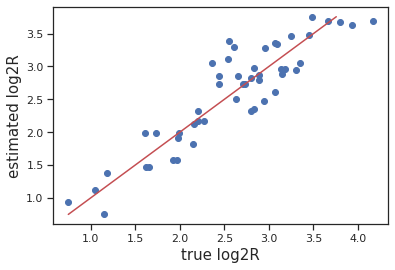

In [11]:
plt.scatter(log2R_true, log2R_pred)
plt.plot([np.min(log2R_pred),np.max(log2R_pred)],[np.min(log2R_pred),np.max(log2R_pred)],c='r')
plt.xlabel('true log2R',fontsize=15)
plt.ylabel('estimated log2R',fontsize=15)
plt.show()

Display the total UMI distribution with raw data and ratio-based corrected data. The corrected distribution should reflect the truth of total mRNA ratio between cell types.

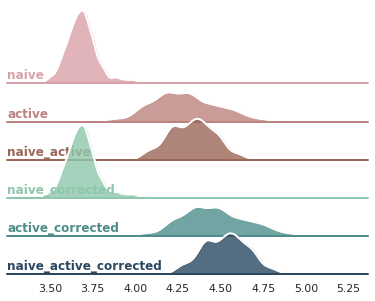

In [12]:
tm.vis.corrected_UMI_hist(adata,
                          groupby = 'danno',
                          groups = ['naive', 'active', 'naive_active'],
                          reference = 'naive',
                          logUMIby = 'log10_totUMIs',
                          ratios = [1,5.9,6.9])

Save data for downstream analyses

In [13]:
adata.write('examples/simulated_data/adata_bc_fit.h5ad')
adata_dbl_mg.write('examples/simulated_data/adata_bc_mg.h5ad')